<a href="https://colab.research.google.com/github/dssikdar/asdrp_QGAN/blob/Chemistry/tryChemSelfies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing
Working with written language is called natural language processing (NLP) and is a much broader field than deep learning. We'll focus just on deep learning in NLP and specifically it's application to molecules and materials. NLP in chemistry would at first appear to be a rich area, especially with the large amount of historic chemistry data existing only in plain text. However, the most work in this area has been on representations of molecules *as text* via the SMILES{cite}`weininger1988smiles` (and recently SELFIES {cite}`Krenn_2020`) encoding. Although InChI is another way to encode molecules{cite}`heller2015inchi`, it cannot distinguish certain classes of molecules (e.g., cisplatin vs transplatin) and according to folk lore is more difficult to train a neural network with. 

The focus of NLP on encoding molecules is mostly due to chemistry relying on publishers which prevent bulk access/ML on publications. Few data (often called corpuses) exists for NLP on research articles. To a large extent then, NLP in chemistry is mostly another way of "featurizing" molecules without resorting to descriptors. This is obviously an essential task in working with molecular data, but I think there are still many important opportunities to explore NLP in areas aside from featurizing molecules. 

One advantage of working with molecules as text relative to graph neural networks (GNNs) is that existing ML frameworks have many more features for working with text. Another reason is that it is easier to train generative models because generating valid text is easier than generating valid graphs. You'll thus see generative/unsupervised learning of chemical space more often done with NLP, whereas GNNs are typically better for supervised learning tasks and can incorporate spatial features (e.g., {cite}`klicpera2019directional,yang2020predicting`). Outside of deep learning, graphical representations are in viewed as more robust than text encodings when used in methods like genetic algorithms and chemical space exploration {cite}`brown2019guacamol`. NLP can be used to understand textual descriptions of materials and molecules, which is essential for *materials* that are defined with more than just the molecular structure.

In NLP, there are a two major tasks which we should be aware of. **Language modeling** means predicting the probability of the next token (word or character) in a sequence, like guessing the last word in a sentence. For chemistry, this is equivalent to predicting a molecule. For materials, this might be predicting a synthesis procedure given a set of ingredients. Language models are statistical models that have a "understanding" of language and can be fine-tuned (trained a second time) for a more specific task, like predicting if a molecule will bind to a protein. **Topic classification** or text classification is predicting probabilities of classes for a sequence. For chemistry, this could be predicting a binary label like "soluble in water" from a SMILES string. The models described below are characterized as seq2vec or seq2seq (which is usually a combined seq2vec + vec2seq). A sequence to sequence model (seq2seq) does language modeling: it actually predicts probabilities for an output sequence. A sequence to vector (seq2vec) model converts a sequence into a vector of real numbers, which can then be used for classification or other tasks.

## Converting Molecules into Text

Before we can begin to use neural networks, we need to convert molecules into text. Simplified molecular-input line-entry system (SMILES) is a de facto standard for converting molecules into a string. SMILES enables molecular structures to be correctly saved in spreadsheets, databases, and input to models that work on sequences like text. Here's an example SMILES string: `CC(NC)CC1=CC=C(OCO2)C2=C1`. SMILES was crucial to the field of cheminformatics and is widely used today beyond deep learning. Some of the first deep learning work was with SMILES strings because of the ability to apply NLP models to SMILES strings.

Let us imagine SMILES as a function whose domain is molecular graphs (or some equivalent complete description of a molecule) and the image is a string. This can be thought of as an **encoder** that converts a molecular graph into a string. The SMILES encoder function is not surjective -- there are many strings that cannot be reached from decoding graphs. The SMILES encoder function is injective -- each graph has a different SMILES string. The inverse of this function, the SMILES **decoder**, cannot have the domain of all strings because some strings do not decode to valid molecular graphs. This is because of the syntax rules of SMILES. Thus, we can regard the domain to be restricted to *valid* SMILES string. In that case, the decoder is surjective -- all graphs are reachable via a SMILES string. The decoder is not injective -- multiple graphs can be reached by SMILES string. 

This last point, the non-injectivity of a SMILES decoder, is a problem identified in database storage and retrieval of compounds. Since multiple SMILES strings map to the same molecular graph, it can happen that multiple entries in a database are actually the same molecule. One way around this is **canonicalization** which is a modification to the encoder to make a unique SMILES string. It can fail though {cite}`o2012towards`. If we restrict ourselves to valid, canonical SMILES, then the SMILES decoder function is injective and surjective -- bijective. 

```{margin} idempotent
One way to assess correctness of the canonicalization process is by testing the idempotent property of the SMILES encoder/decoder pair. That is, if we decode/encode a canonical SMILES string we should get back the same string.
```

The difficulty of canonicalization and thus perceived weakness of SMILES in creating unique strings led (in part) to the creation of InChi strings. InChI is an alternative that is inherently canonical. InChI strings are typically longer and involve more tokens, which seems to affect their use in deep learning. InChI as a representation is often worse with the same amount of data vs SMILES. 

If you've read the previous chapters on equivariances ({doc}`data` and {doc}`Equivariant`), a natural question is if SMILES is permutation invariant. That is, if you change the order of atoms in the molecular graph that has no effect on chemistry, is the SMILES string identical? Yes, if you use the canonical SMILES. So in a supervised setting, using canonical SMILES gives an atom ordering permutation invariant neural network because the representation *will not* be permuted after canonicalization. Be careful; you should not trust that SMILES you find in a datset are canonical . 

### SELFIES

Recent work from Krenn et al. developed an alternative approach to SMILES called SELF-referencIng Embedded Strings (SELFIES){cite}`Krenn_2020`. Every string is a valid molecule. Note that the characters in SELFIES are not all ASCII characters, so it's not like every sentence encodes a molecule (would be cool though). SELFIES is an excellent choice for generative models because any SELFIES string automatically decodes to a valid molecule. SELFIES, as of 2021, is not directly canonicalized though and thus is not permutation invariant by itself. However, if you add canonical SMILES as an intermediate step, then SELFIES are canonical. It seems that models which output a molecule (generative or supervised) benefit from using SELFIES instead of SMILES because the model does not need to learn how to make valid strings -- all strings are already valid SELFIES {cite}`rajan2020decimer`. This benefit is less clear in supervised learning and no difference has been observed empirically{cite}`chithrananda2020chemberta`. Here's a blog post giving an [overview of SELFIES and its applications](https://aspuru.substack.com/p/molecular-graph-representations-and).


### Demo

You can get a sense for SMILES and SELFIES in this [demo page](https://whitead.github.io/molecule-dream/) that uses a RNN (discussed below) to generate SMILES and SELFIES strings.

### Stereochemistry

SMILES and SELFIES can treat stereoisomers, but there are a few complications. `rdkit`, the dominant Python package, [cannot treat non-tetrahedral chiral centers with SMILES](https://github.com/rdkit/rdkit/issues/3220) as of 2021. For example, even though SMILES according to its specification can correctly distinguish cisplatin and transplatin, the implementation of SMILES in `rdkit` cannot. Other examples of chirality that are present in the SMILES specification but not implementations are planar and axial chirality. SELFIES relies on SMILES (specifically the `rdkit` implementation) and thus is also susceptible to this problem. This is an issue for any organometallic compounds. In organic chemistry though, most chirality is tetrahedral and correctly treated by `rdkit`.

### What is a chemical bond?

More broadly, the idea of a chemical bond is a concept created by chemists. You cannot measure the existence of a chemical bond in the lab and it is not some quantum mechanical operator with an observable. There are certain molecules which cannot be represented by classic single,double,triple,aromatic bonded representations, like ferrocene or diborane. This bleeds over to text encoding of a molecule where the bonding topology doesn't map neatly to bond order. The specific issue this can cause is that multiple unique molecules may appear to have the same encoding (non-injective). In situations like this, it is probably better to just work with the exact 3D coordinates and then bond order or type is less important than distance between atoms.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy tensorflow
```

````

## Recurrent Neural Networks

```{margin}
String is a synonym for sequence here. Character and symbol are synonyms for token (single element of the string).
```

Recurrent neural networks (RNN) have been by far the most popular approach to working with molecular strings. RNNs have a critical property that they can have different length input sequences, making it appropriate for SMILES or SELFIES which both have variable length. RNNs have recurrent layers that consume an input sequence element-by-element. Consider an input sequence $\mathbf{X}$ which is composed of a series of vectors (recall that characters or words can be represented with one-hot or embedding vectors) $\mathbf{X} = \left[\vec{x}_0, \vec{x}_1,\ldots,\vec{x}_L\right]$. The RNN layer function is binary and takes as input the $i$th element of the input sequence and the output from the $i - 1$ layer function. You can write it as:

\begin{equation}
f(f\ldots f(\vec{x}_0,\vec{0}), \vec{x}_1), \vec{x}_2)\ldots \vec{x}_L)
\end{equation}

Commonly we would like to actually see and look at the these intermediate outputs from the layer function $f_4(\vec{x}_4, f_3(\ldots)) = \vec{h}_4$. These $\vec{h}$s are called the hidden state because of the connection between RNNs and Markov State Models. We can **unroll** our picture of an RNN to be:

```{figure} ./rnn.jpg
----
name: rnn
width: 400px
----
Unrolled picture of RNN. 
```

where the initial hidden state is assumed to be $\vec{0}$, but could be trained. The output at the end is shown as $\vec{y}$. *Notice there are no subscripts on $f$ because we use the same function and weights at each step*. This re-use of weights makes the choice of parameter number independent of input lengths, which is also necessary to make the RNN accommodate arbitrary length input sequences. It should be noted that the length of $\vec{y}$ may be a function of the input length, so that the $\vec{h}_i$ may be increasing in length at each step to enable an output $\vec{y}$. Some diagrams of RNNs will show that by indicating a growing output sequence as an additional output from $f(\vec{x}_i, h_{i-1})$.

Interestingly, the form of $f(\vec{x}, \vec{h})$ is quite flexible based on the discussion above. There have been hundreds of ideas for the function $f$ and it is problem dependent. The two most common are long short-term memory (LSTM) units and gated recurrent unit (GRU). You can spend quite a bit of time trying to reason about [these functions](http://d2l.ai/chapter_recurrent-modern/gru.html), understanding how [gradients propagate nicely through them](http://d2l.ai/chapter_recurrent-neural-networks/bptt.html), and there is an analogy about how they are inspired by human memory. Ultimately, they are used because they perform well and are widely-implemented so we do not need to spend much time on these details. The main thing to know is that GRUs are simpler and faster, but LSTMs seem to be better at more difficult sequences. Note that $\vec{h}$ is typically 1-3 different quantities in modern implementations. Another details is the word **units**. Units are like the hidden state dimension, but because the hidden state could be multiple quantities (e.g., LSTM) we do not call it dimension. 

```{margin}
Actually, they are not used so much anymore because transformers seem to be a direct replacement for RNNs. 
```

The RNN layer allows us to input an arbitrary length sequence and outputs a label which could depend on the length of the input sequence. You can imagine that this could be used for regression or classification. $\hat{y}$ would be a scalar. Or you could take the output from an RNN layer into an MLP to get a class.

### Generative RNNs

An interesting use case for an RNN is in unsupervised generative models, where we try to predict new examples. This means that we're trying to learn $P(\mathbf{X})$ {cite}`segler2018generating`. With a generative RNN, we predict the sequence one symbol at a time by conditioning on a growing sequence. This is called **autoregressive** generation.

\begin{equation}
P(\mathbf{X}) = \prod P(\vec{x}_L | \vec{x}_{L - 1}, \vec{x}_{L - 2}, \ldots,\vec{x}_0)\ldots P(\vec{x}_1 | \vec{x}_0) P(\vec{x}_0))
\end{equation}

```{margin}
This is also called **self-supervised** instead of unsupervised learning. The distinction is that we're creating labels by chopping up our training data -- so it is supervised. But it's not quite supervised because labels do not need to be supplied.
```

The RNN is trained to take as input a sequence and output the probability for the next character. Our network is trained to be this conditional probability: $P(\vec{x}_i | \vec{x}_{L - i}, \vec{x}_{L - i}, \ldots, \vec{x}_0)$. What about the $P(\vec{x}_0)$ term? Typically we just *pick* what the first character should be. Or, we could create an artificial "start" character that marks the beginning of a sequence (typically `0`) and always choose that. 

We can train the RNN to agree with $P(\vec{x}_i | \vec{x}_{L - i}, \vec{x}_{L - i}, \ldots, \vec{x}_0)$ by taking an arbitrary sequence $\vec{x}$ and choosing a split point $\vec{x}_i$ and training on the proceeding sequence elements. This is just multi-class classification. The number of classes is the number of available characters and our model should output a probability vector across the classes. Recall the loss for this cross-entropy. 

When doing this process with SMILES an obvious way to judge success would be if the generated sequences are valid SMILES strings. This at first seems reasonable and was used as a benchmark for years in this topic. However, this is a low-bar: we can find valid SMILES in much more efficient ways. You can download 77 million SMILES {cite}`chithrananda2020chemberta` and you can find vendors that will give you a multi-million entry database of purchasable molecules. You can also just use SELFIES and then an untrained RNN will generate only valid strings, since SELFIES is bijective. A more interesting metric is to assess if your generated molecules are in the same region of chemical space as the training data{cite}`segler2018generating`. I believe though that generative RNNs are relatively poor compared with other generative models in 2021. They are still strong though when composed with other architectures, like VAEs {cite}`gomez2018automatic` or encoder/decoder {cite}`rajan2020decimer`.

## Masking & Padding

As in our {doc}`gnn` chapter, we run into issues with variable length inputs. The easiest and most compute efficient way to treat this is to pad (and/or trim) all strings to be the same length, making it easy to batch examples. A memory efficient way is to not batch and either batch gradients as a separate step or trim your sequences into subsequences and save the RNN hidden-state between them. Due to the way that NVIDIA has written RNN kernels, padding should always be done on the right (sequences all begin at index 0). The character used for padding is typically 0. Don't forget, we will always first convert our string characters to integers corresponding to indices of our vocabulary (see {doc}`layers`). Thus, remember to make sure that the index 0 should be reserved for padding. 

Masking is used for two things. Masking is used to ensure that the padded values are not accidentally considered in training. This is framework dependent and you can read about [Keras here](https://keras.io/guides/understanding_masking_and_padding/), which is what we'll use. The second use for masking is to do element-by-element training like the generative RNN. We train each time with a shorter mask, enabling it to see more of the sequence. This prevents you from needing to slice-up the training examples into many shorter sequences. This idea of a right-mask that prevents the model for using characters farther in the sequence is sometimes called **causal masking** because we're preventing characters from the "future" affecting the model. 

## RNN Solubility Example

Let's revisit our solubility example from before. We'll use a GRU to *encode* the SMILES string into a vector and then apply a dense layer to get a scalar value for solubility. Let's revisit the solubility AqSolDB{cite}`Sorkun2019` dataset from {doc}`../ml/regression`. Recall it has about 10,000 unique compounds with measured solubility in water (label) and their SMILES strings. Many of the steps below are explained in the {doc}`layers` chapter that introduces Keras and the principles of building a deep model.

I've hidden the cell below which sets-up our imports and shown a few rows of the dataset.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv("selfies_csv_data.csv")
#features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)

In [10]:
soldata = soldata.drop('Unnamed: 0', axis=1)
soldata.head()

,selfies,Solubility
0,[Br-1].[C][C][C][C][C][C][C][C][C][C][C][C][C]...,-3.616127
1,[O][=C][N][C][=C][C][=C][C][=C][C][=C][C][Ring...,-3.254767
2,[Cl][C][=C][C][=C][Branch1][Ring1][C][=O][C][=...,-2.177078
3,[Zn+2].[C][C][Branch1][=Branch2][C][=C][C][=C]...,-3.924409
4,[C][O][C][Ring1][Ring1][C][N][Branch1][#Branch...,-4.662065


We'll extract our labels and convert SMILES into padded characters. We make use of a **tokenizer**, which is essentially a look-up table for how to go from the characters in a SMILES string to integers. To make our model run faster, I will filter out very long SMILES strings. 

In [11]:
# filter out long smiles
smask = [len(s) <= 96 for s in soldata.selfies]
print(f"Removed {soldata.shape[0] - sum(smask)} long selfies strings")
filtered_soldata = soldata[smask]

# make tokenizer with 128 size vocab and
# have it examine all text in dataset
vocab_size = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    vocab_size, filters="", char_level=True
)
tokenizer.fit_on_texts(filtered_soldata.selfies)

Removed 5463 long selfies strings


In [12]:
# now get padded sequences
seqs = tokenizer.texts_to_sequences(filtered_soldata.selfies)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding="post")

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, filtered_soldata.Solubility))
# now split into val, test, train and batch
N = soldata.shape[0]
split = int(0.1 * N)
test_data = data.take(split).batch(16)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

We're now ready to build our model. We will just use an embedding then RNN and some dense layers to get to a final predicted solubility. 

In [13]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True)
)

# RNN layer
model.add(tf.keras.layers.GRU(32))
# a dense hidden layer
model.add(tf.keras.layers.Dense(32, activation="relu"))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          2048      
                                                                 
 gru (GRU)                   (None, 32)                4800      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________


Now we'll compile our model and train it. This is a regression problem, so we use mean squared error for our loss. 

In [15]:
model.compile(tf.optimizers.Adam(1e-2), loss="mean_squared_error")
result = model.fit(train_data, validation_data=val_data, epochs=25, verbose=1)

Epoch 1/25
133/133 [==============================] - 15s 73ms/step - loss: 2.3571 - val_loss: 4.4787
Epoch 2/25
133/133 [==============================] - 8s 63ms/step - loss: 1.5190 - val_loss: 4.0342
Epoch 3/25
133/133 [==============================] - 8s 63ms/step - loss: 1.1330 - val_loss: 4.0370
Epoch 4/25
133/133 [==============================] - 8s 63ms/step - loss: 0.9720 - val_loss: 4.1008
Epoch 5/25
133/133 [==============================] - 8s 63ms/step - loss: 0.8575 - val_loss: 3.8181
Epoch 6/25
133/133 [==============================] - 8s 62ms/step - loss: 0.8285 - val_loss: 3.8242
Epoch 7/25
133/133 [==============================] - 9s 69ms/step - loss: 0.7288 - val_loss: 3.6885
Epoch 8/25
133/133 [==============================] - 8s 63ms/step - loss: 0.7349 - val_loss: 3.6438
Epoch 9/25
133/133 [==============================] - 8s 63ms/step - loss: 0.6525 - val_loss: 3.6333
Epoch 10/25
133/133 [==============================] - 8s 63ms/step - loss: 0.6308 - val_l

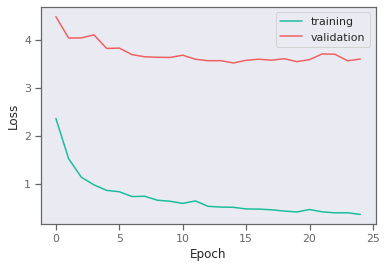

In [16]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

As usual, we could keep training and I encourage you to explore adding regularization or modifying the architecture. Let's now see how the test data looks. 

In [17]:
# evaluate on test data
yhat = []
test_y = []
for x, y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

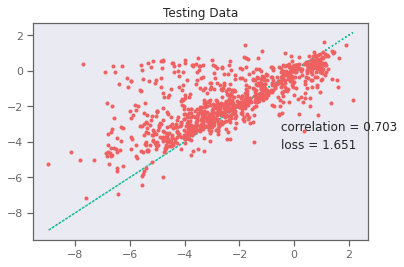

In [18]:
# plot test data
plt.plot(test_y, test_y, ":")
plt.plot(test_y, yhat, ".")
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}")
plt.title("Testing Data")
plt.show()

Linear regression from {doc}`../ml/regression` still wins, but this demonstrates the use of an RNN for this task. 

## Transformers

Transformers have been well-established now as the current state of the art for language modeling tasks. The transformer architecture is actually just self-attention repeated in multiple layers. The paper describing the architecture was quite a breakthrough. At the time, the best models used convolutions, recurrence, attention and encoder/decoder. The paper title was "attention is all you need" and that is basically the conclusion {cite}`vaswani2017attention`. They found that multi-head attention (including self-attention) was what mattered and this led to **transformers**. Transformers are simple and *scalable* because each layer is nearly the same operation. This has led to simple "scaling-up the language model" resulting in things like GPT-3, which has billions of parameters and cost millions of dollars to train. GPT-3 is also surprisingly good and versatile. The single model is able to answer questions, describe computer code, translate languages, and infer recipe instructions for cookies. I highly recommend reading the paper, it's quite interesting{cite}`brown2020language`. 

```{margin}
Considering the whole sequence simultaneously is also possible with bi-directional RNNs that read a sequence simultaneously from both ends -- meaning context before and after a missing character can be used for training. 
```

There are two principles from the transformer that interest us. One is of course that it is a simple and effective replacement for RNNs. The second is that the transformer considers the whole sequence simultaneously. This has a few consequences. The first is that it is again input size dependent. However, we can pad and mask to get around that. The second consequence is that the self-supervised/unsupervised training can be more interesting than just predict the next character in the string. Instead, we can randomly delete characters and ask the transformer to infer the missing character. This is how transformers are typically "pre-trained" -- by feeding a bunch of masked sequences to teach the transformer the language. Then, if desired, the transformer can be refined with labels on your specific task. Transformers and their pre-training training procedure have led to pre-trained chemistry specific models that can be downloaded and used immediately on chemistry data, like ChemBERTa {cite}`chithrananda2020chemberta`. These pre-trained models have been trained on 77 million molecules and so should already have some "intuition" about molecular structures and they indeed do well on supervised learning tasks.


### Architecture

The transformer is fundamentally made-up of layers of multi-head attention blocks as discussed in {doc}`attention`.  The overall architecture is an encoder/decoder like seen in {doc}`VAE`. Like the variational autoencoder, the decoder portion can be discarded and only the encoder is used for supervised tasks. Thus, you might **pre-train** the encoder/decoder with self-supervised training (strings with withheld characters) on a large dataset without labels and then use only the encoder for a regression tasks with a smaller dataset.

```{margin}
Some have recently argued that convolutions might be as effective as transformers with some tuning. If substantiated, this could upend NLP because convolutions are simpler to understand, parallelize, and interpret. {cite}`tay2021pretrained`
```

What exactly is going in and out of the encoder/decoder? The transformer is an example of a sequence to sequence (seq2seq) model and the most obvious interpretation is translating between two languages like English to French. The encoder takes in English and the decoder produces French. Or maybe SMILES to IUPAC name. However, that requires "labels" (the paired sequence). To do self-supervised training pre-training, we need the input to the encoder to be a sequence missing some values and the decoder output to be the same sequence with probabilities for each position values filled in. This is called **masked** self-supervised training. If you pre-train in this way, you can do two tasks with your pre-trained encoder/decoder. You can use the encoder alone as a way to embed a string into real numbers and then a downstream task like predicting a molecule's enthalpy of formation from its SMILES string. The other way to use a model trained this way is for autoregressive generation. The input might be a few characters or a *prompt* {cite}`reynolds2021prompt` specifically crafted like a question. This is similar the generative RNN, although it allows more flexibility. 


```{margin}
Self-supervised training is not just for transformers! It has been successfully applied to graph neural networks as well {cite}`wang2021molclr`.
```

There are many details to transformers and "hand-tuned" hyperparameters. Examples in modern transformers are layer normalizations (similar to batch normalization), embeddings, dropout, weight decay, learning rate decay, and position information encoding {cite}`liu2019roberta`. Position information is quite an interesting topic -- you need to include the location of a token (character) in its embedding. Was it the first character or last character?  This is key because when you compute the attention between tokens, the relative location is probably important. Some recent promising work proposed a kind of phase/amplitude split, where the position is the phase and the amplitude is the embedding{cite}`su2021roformer`. 

If you would like to see how to implement a real transformer with most of these details, take a look at this [Keras tutorial](https://keras.io/examples/generative/text_generation_with_miniature_gpt/). Because transformers are so tightly coupled with pre-training, there has been a great deal of effort in pre-training models. Aside from [GPT-3](https://en.wikipedia.org/wiki/GPT-3), a general model pre-trained on an enormous corpus of billions of sequences from multiple languages, there are many language specific pre-trained models. [Hugging Face](https://huggingface.co/) is a company and API that hosts pre-trained transformers for specific language models like Chinese language, XML, SMILES, or question and answer format. These can be quickly downloaded and utilized, enabling rapid use of state-of-the art language models.

## Using the Latent Space for Design

One of the most interesting applications of these encoder/decoder seq2seq models in chemistry is their use for doing optimal design of a molecule. We pre-train an encoder/decoder pair with masking. The encoder brings our molecule to a continuous representation (seq2vec). Then we can do regression in this vector space for whatever property we would like (e.g., solubility). Then we can optimize this regressed model, finding an input vector that is a minimum or maximum, and finally convert that input vector into a molecule using the decoder {cite}`gomez2018automatic`. The vector space output by the encoder is called the **latent space** like we saw in {doc}`VAE`. Of course, this works for RNN seq2seq models, transformers, or convolutions. 

## Representing Materials as Text

Materials are an interesting problem for deep learning because they are not defined by a single molecule. There can be information like the symmetry group or components/phases for a composite material. This creates a challenge for modeling, especially for real materials that have complexities like annealing temperature, additives, and age. From a philosophical point of view, a material is defined by how it was constructed. Practically that means a material is defined by the text describing its synthesis {cite}`butler2018machine`. This is an idea taken to its extreme in Tshitoyan et al. {cite}`tshitoyan2019unsupervised` who found success in representing thermoelectrics via the text describing their synthesis {cite}`swain2016chemdataextractor`. This work is amazing to me because they had to manually collect papers (publishers do not allow ML/bulk download on articles) and annotate the synthesis methods. Their seq2vec model is relatively old (2 years!) and yet there has not been much progress in this area. I think this is a promising direction but challenging due to the data access limitations. For example, recent progress by Friedrich et al. {cite}`friedrich2020sofc` built a pre-trained transformer for solid oxide fuel cells materials but their corpus was limited to open access articles (45) over a 7 year period. This is one critical line of research that is limited due to copyright issues. Text can be copyrighted, not data, but maybe someday a court can be convinced that they are interchangeable. 


## Applications

As discussed above, molecular design has been one of the most popular areas for NLP models in chemistry {cite}`segler2018generating,merk2018novo,gomez2018automatic`. Transformers have been found to be excellent at predicting chemical reactions. Schwaller et al. {cite}`schwaller2020predicting` have shown how to do retrosynthetic  pathway analysis with transformers. The transformers take as input just the reactants and reagents and can predict the products. The models can be calibrated to include uncertainty estimates {cite}`schwaller2019molecular` and predict synthetic yield {cite}`schwaller2020prediction`. Beyond taking molecules as input, Vaucher et al. trained a seq2seq transformer that can translate the unstructured methods section of a scientific paper into a set of structured synthetic steps {cite}`vaucher2020automated`. Finally, Schwaller et al. {cite}`schwaller2021mapping` trained a transformer to classify reactions into organic reaction classes leading to a [fascinating map of chemical reactions](https://rxn4chemistry.github.io/rxnfp/tmaps/tmap_ft_10k.html).

## Summary

* Text is a natural representation of both molecules and materials
* SMILES and SELFIES are ways to convert molecules into strings
* Recurrent neural networks (RNNs) are an input-length independent method of converting strings into vectors for regression or classification
* RNNs can be trained in seq2seq (encoder/decoder) setting by having it predict the next character in a sequence. This yields a model that can autoregressively generate new sequences/molecules
* Withholding or masking sequences for training is called self-supervised training and is a pre-training step for seq2seq models to enable them to learn the properties of a language like English or SMILES
* Transformers are currently the best seq2seq models
* The latent space of seq2seq models can be used for molecular design
* Materials can be represented as text which is a complete representation for many materials

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```